In [10]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Machine Learning

**🎯 Learning Objectives**

By the end of this notebook, you should be able to:

1. **Differentiate** supervised vs. unsupervised learning and select appropriate models for tabular, text, image, and time-series data.  
2. **Build baselines** and compare models using proper **cross-validation** and **out-of-sample** evaluation.  
3. **Control overfitting** with **regularization**, feature engineering, and early stopping.  
4. **Interpret models** (coefficients, feature importance, SHAP/partial dependence) to inform decisions.  
5. **Deploy practical heuristics** about when each method shines given **data type**, **size**, **noise**, and **compute** constraints.



The basic issue in finance is that we want to know how expected returns move around, but we only observe realized returns

We can compile lots and lots of information/data about different assets

We saw how to run OLS regression of returns on a large set of characteristics ( I think it was 30)

But we didn;t even think interactions among them--say the value characteristic might have different information for returns for small vs big stocks--considering all these interactions would leads us to estimate 900 coefficients. And of course there are potentially many more characteristics and their lags that could be informative for expected returns and co-movement

You can see that very quickly you run out of data

Here where recent advances in machine learning can be super useful

In the end of the day we want to estimate a function F that maps observed characteristics in future returns


$$R_{t+1}=F(X_t)$$

This function can be linear

$$R_{t+1}=BX_t$$


 or linear in the interactions

 $$R_{t+1}=BX_t+C X_t ⊗ X_t$$

 Or have even higher order or non-linear relationships, that is instead of including the chracteristic , we include dummies according to the rank of the characteristic relative to other stocks in the cross-sectional

 Here where the tools if machine learning can be useful to us

 We will now discuss a few of the most used methods


- **Lasso Regression** (L1 regularization)
- **Random Forest Regression**
- **Gradient Boosted Regression Trees (GBRT)**
- **Elastic Net Regression** (combination of L1 and L2 regularization)
- **Neural Network Regression** (customizable number of layers)

We will apply those to our data set

We will have a training/estimation   sample (1972-1992) and a tuning sample (1992-2002)

We will not use it today but I also reserved a test sample (2002-2016) for you to evaluate your favorite model.



In [ ]:
# url = "../../assets/data/characteristics_raw.csv"

# df_X = pd.read_csv(url)
# # This simply shits the date to be in an end of month basis


# df_X['date'] = pd.to_datetime(df_X['date'], format='%m/%Y')
# df_X.set_index(['date','permno'],inplace=True)

# df_X['1972':'1991'].to_pickle('../../assets/data/characteristics19721991.pkl')
# df_X['1992':'2001'].to_pickle('../../assets/data/characteristics19922001.pkl')
# df_X['2002':].to_pickle('../../assets/data/characteristics20022016.pkl')

In [11]:
url = "https://github.com/amoreira2/Fin418/blob/main/assets/data/characteristics19721991.pkl?raw=true"

df_train = pd.read_pickle(url)
df_train=df_train.drop(columns=['rf','rme'])
display(df_train)
url = "https://github.com/amoreira2/Fin418/blob/main/assets/data/characteristics19922001.pkl?raw=true"
df_tuning = pd.read_pickle(url)
df_tuning=df_tuning.drop(columns=['rf','rme'])
display(df_tuning)

re       size     value      prof  fscore  debtiss  \
date       permno                                                             
1972-07-01 10006   0.028600  12.399869 -0.125361 -1.662274       1        0   
           10102   0.039757  12.217334  0.354954 -1.533574       3        0   
           10137  -0.044767  13.069874 -0.088697 -2.285618       2        1   
           10145  -0.062422  13.608366  0.075484 -1.563468       3        0   
           10153  -0.065600  11.752572  0.944457 -1.443505       2        0   
...                     ...        ...       ...       ...     ...      ...   
1991-01-01 90369   0.047830  12.802441 -0.693011 -3.167399       3        1   
           90609   0.297830  14.421899 -1.469354 -0.192073       5        0   
           91380   0.277409  14.513939 -0.929698 -0.441911       6        1   
           91695   0.110589  12.718260 -1.582293 -0.409848       5        1   
           92655   0.177596  12.899849 -1.385607 -0.341648       6        1   

                   repurch     nissa    growth  aturnover  ...    momrev  \
date       permno                                          ...             
1972-07-01 10006         0  0.691632  0.055546  -0.402127  ...  0.241023   
           10102         0  0.702357  0.032625  -0.280661  ...  0.280555   
           10137         0  0.735522  0.130297  -1.473819  ... -0.024738   
           10145         0  0.693165  0.033959  -0.210598  ...  0.529800   
           10153         1  0.688459  0.016692   0.087675  ...  0.158727   
...                    ...       ...       ...        ...  ...       ...   
1991-01-01 90369         0  0.693650  0.204222  -1.182231  ...  0.431073   
           90609         0  0.795055  0.421466   0.196485  ... -0.311436   
           91380         0  0.697018  0.092376   0.446092  ...  0.253155   
           91695         0  0.693282 -0.004634   0.234171  ... -0.006908   
           92655         0  0.884419  0.340396   0.553001  ...  0.298045   

                     valuem     nissm     strev      ivol   betaarb   indrrev  \
date       permno                                                               
1972-07-01 10006   0.046338  0.691632 -0.025281  0.015680  0.875315 -0.033445   
           10102   0.525299  0.702357 -0.066667  0.013668  1.167972 -0.029807   
           10137  -0.042177  0.735522 -0.034483  0.010347  0.755496 -0.020019   
           10145   0.062691  0.693165 -0.036735  0.018345  1.097189 -0.011115   
           10153   1.029572  0.688459 -0.107407  0.020491  1.246057 -0.079017   
...                     ...       ...       ...       ...       ...       ...   
1991-01-01 90369  -0.612392  0.692859  0.028794  0.020753  0.789805 -0.019639   
           90609  -2.001907  0.725049  0.047619  0.023579  1.373399 -0.001491   
           91380  -0.340558  0.695715  0.052273  0.026668  1.325531 -0.026854   
           91695  -1.302569  0.692102  0.117647  0.028104  0.783925  0.045506   
           92655  -1.877044  0.875576  0.148148  0.028847  1.096923  0.099715   

                      price       age     shvol  
date       permno                                
1972-07-01 10006   3.769883  5.135798  0.264547  
           10102   2.862201  5.135798  0.159992  
           10137   3.044522  5.135798  0.102413  
           10145   3.384390  5.135798  0.208178  
           10153   2.484907  5.135798  0.215979  
...                     ...       ...       ...  
1991-01-01 90369   3.496508  4.174387  0.482675  
           90609   3.496508  4.304065  1.249267  
           91380   2.442347  4.219508  0.417471  
           91695   3.167583  4.204693  0.589516  
           92655   3.146305  4.343805  1.262840  

[204284 rows x 30 columns]

re       size     value      prof  fscore  debtiss  \
date       permno                                                             
1992-01-01 10078   0.071490  14.803577 -0.821429 -0.351670       5        1   
           10095  -0.131137  13.042999 -1.288738 -2.907817       2        1   
           10104   0.272462  13.962658 -0.943996  0.072345       3        0   
           10107   0.077499  16.289499 -2.240325 -0.123331       5        1   
           10119   0.158277  13.891799 -0.598919 -2.420088       4        1   
...                     ...        ...       ...       ...     ...      ...   
2001-01-01 88664  -0.270994  14.544541 -2.222151 -0.639122       6        1   
           90100  -0.004434  14.481504 -0.821788 -1.134622       7        0   
           90609   0.647295  14.915539 -2.160840 -0.608490       6        1   
           91380  -0.009058  13.713922  0.137959 -0.303891       6        1   
           92655  -0.086296  16.449309 -0.847793 -0.821228       6        0   

                   repurch     nissa    growth  aturnover  ...    momrev  \
date       permno                                          ...             
1992-01-01 10078         0  0.713175  0.337526   0.326859  ... -0.375068   
           10095         1  0.823573  0.299850  -2.007233  ...  0.097856   
           10104         0  0.712626  0.536861   0.209624  ... -0.919460   
           10107         1  0.703894  0.427835   0.068269  ... -0.010327   
           10119         0  0.693147  0.153250  -0.435732  ...  0.056359   
...                    ...       ...       ...        ...  ...       ...   
2001-01-01 88664         1  0.706994  0.415774   0.054443  ...  0.117828   
           90100         1  0.655505  0.036674  -0.057457  ... -0.123972   
           90609         1  0.673995  0.009418  -0.422648  ... -0.183386   
           91380         1  0.699451 -0.106341   0.617338  ... -0.792238   
           92655         1  0.661662  0.057290   0.644070  ... -0.115775   

                     valuem     nissm     strev      ivol   betaarb   indrrev  \
date       permno                                                               
1992-01-01 10078  -0.827133  0.688756  0.182292  0.036514  1.279770  0.143753   
           10095  -2.439453  0.879456  0.497268  0.044026  1.046930  0.331867   
           10104  -1.741446  0.710315  0.074074  0.032754  1.434134 -0.091418   
           10107  -2.681148  0.708289  0.143959  0.013396  1.383749 -0.021534   
           10119  -0.886515  0.693128  0.098684  0.015079  0.760442 -0.015104   
...                     ...       ...       ...       ...       ...       ...   
2001-01-01 88664  -2.832748  0.734983  0.158508  0.030403  0.917149  0.241260   
           90100  -0.702888  0.694680  0.291677  0.043108  0.593961  0.162599   
           90609  -0.172097  0.679562 -0.017647  0.038304  1.443601  0.065105   
           91380  -1.032178  0.701598  0.282815  0.037141  0.831341  0.137473   
           92655  -1.687913  0.674296  0.046351  0.021378  0.834816 -0.021866   

                      price       age     shvol  
date       permno                                
1992-01-01 10078   3.345508  4.276666  1.612871  
           10095   4.226834  4.276666  2.038652  
           10104   2.674149  4.276666  1.062730  
           10107   4.711780  4.276666  0.735207  
           10119   3.038552  4.276666  0.145575  
...                     ...       ...       ...  
2001-01-01 88664   4.129148  5.214936  1.044554  
           90100   2.560130  4.997212  0.430254  
           90609   1.652258  5.267858  1.329642  
           91380   3.308351  5.236442  1.157457  
           92655   4.117003  5.283204  0.619079  

[99615 rows x 30 columns]

##  **Lasso Regression**
Lasso (Least Absolute Shrinkage and Selection Operator) regression is a linear regression model with L1 regularization. It minimizes the following objective:

$$
\min_{\beta} \left( \frac{1}{2n} \sum_{i=1}^n (y_i - X_i^\top \beta)^2 + \alpha \|\beta\|_1 \right)
$$

- **Key Characteristics**:
  - Shrinks some coefficients to exactly zero, effectively performing feature selection.
  - Useful for sparse models where only a subset of predictors are important.
  - Struggles with multicollinearity, as it tends to arbitrarily select one among correlated predictors.




1. **Feature Extraction**: `X` is extracted from the columns after the first 3. `Y` is the excess return.
2. **Feature Standardization**: Standardizes `X` using `StandardScaler`, which is important for Lasso because it is sensitive to feature scaling.
3. **Lasso Regression**: Fits a Lasso regression model with a specified regularization strength (`alpha`).
4. **Evaluation**: Outputs the coefficients and \( R^2 \) score on test data, if a train-test split is used.

You can adjust the `alpha` parameter in `Lasso()` to tune the regularization strength. A smaller value of `alpha` reduces regularization, while a larger value increases it.

Note that here we are implicitly using the tuning sample to pick the amount of regularization. So once we pick our favorite alpha, which looks like to 0.002, we need to look at some other sample to if that worked


In [ ]:
#We will start by standardizing our characteristics. This is done by subtracting the mean and dividing by the standard deviation.


X_train = df_train.iloc[:, 1:]
X_train= X_train.groupby('date').apply(lambda x: (x - x.mean()) / x.std())

X_tuning = df_tuning.iloc[:, 1:]
X_tuning= X_tuning.groupby('date').apply(lambda x: (x - x.mean()) / x.std())

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split



from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Extract Y (excess return) and X (characteristics)

Y_train = df_train.iloc[:, 0]   # Excess return

Y_tuning = df_tuning.iloc[:, 0]   # Excess return


# # Perform Lasso regression
lasso = Lasso(alpha=0.0025)  # You can adjust the alpha (regularization strength)
lasso.fit(X_train, Y_train)

# Coefficients and intercept
print("Lasso Coefficients:", lasso.coef_)
print("Intercept:", lasso.intercept_)



Y_pred = lasso.predict(X_tuning)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(Y_tuning, Y_pred)
print("Mean Squared Error (MSE):", mse)

mae= mean_absolute_error(Y_tuning, Y_pred)
print("Mean Absolute Error (MAE):", mae)

r2 = r2_score(Y_tuning, Y_pred)
print("R-squared (R2):", r2)

Lasso Coefficients: [-0.          0.          0.          0.         -0.          0.
 -0.         -0.          0.         -0.          0.         -0.
  0.         -0.          0.          0.          0.          0.
  0.00031046 -0.          0.         -0.         -0.         -0.
 -0.         -0.00223662 -0.          0.         -0.        ]
Intercept: 0.005779088395769684
Mean Squared Error (MSE): 0.01145434617567078
Mean Absolute Error (MAE): 0.07446115851398497
R-squared (R2): -0.00030052087524023996


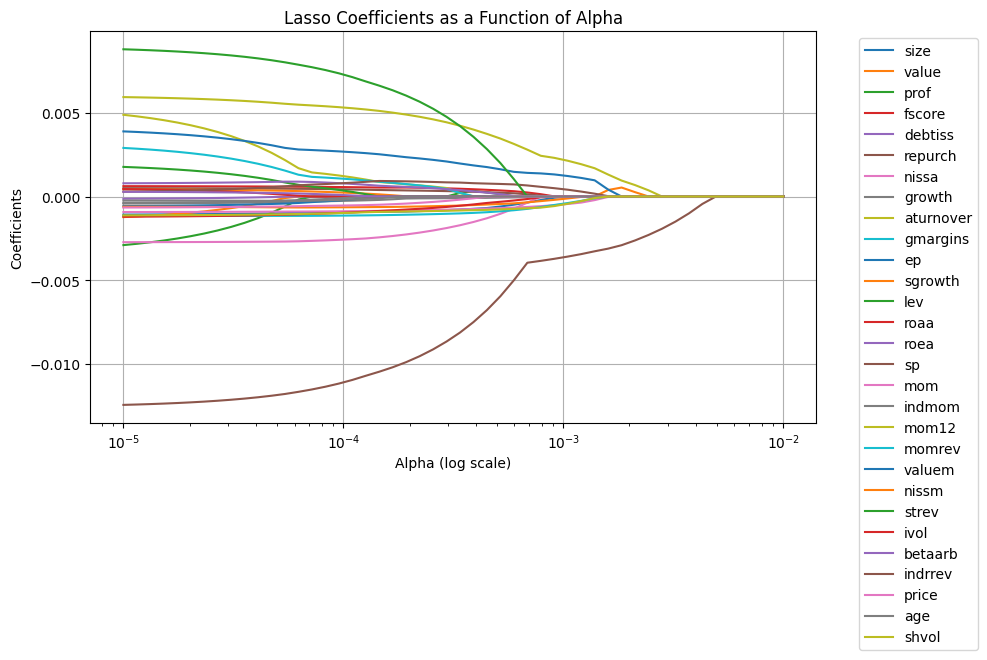

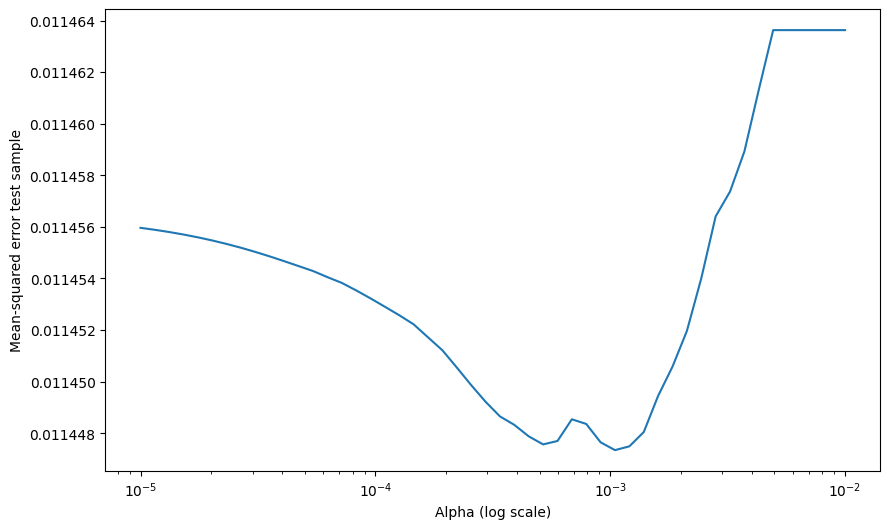

In [12]:

# Define a range of alpha values
alphas = np.logspace(-5, -2, 50)  # range for alphas
coefficients = []
mses=[]
# Perform Lasso regression for each alpha
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)  # Ensure convergence with high iterations
    lasso.fit(X_train, Y_train)
    coefficients.append(lasso.coef_)
    Y_pred = lasso.predict(X_tuning)
    mse = mean_squared_error(Y_tuning, Y_pred)
    mses.append(mse)


# Convert coefficients to a NumPy array for plotting
coefficients = np.array(coefficients)

# Plot the coefficients as a function of alpha
plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i])

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as a Function of Alpha')
plt.legend(df_train.iloc[:, 1:].columns, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(alphas, mses)
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean-squared error test sample')
plt.xscale('log')
plt.show()



Note we are using Mean-squared error as way to evaluate our model

To compute the **Mean Squared Error (MSE)** for the Lasso model after fitting it to the training data, you can use the `mean_squared_error` function from `sklearn.metrics`. Here's how you can do it based on your original code:

Steps to Compute MSE:
1. **Make Predictions**:
   - Use `lasso.predict(X_test)` to get predictions on the test set.

2. **Compute MSE**:
   - Compare the predicted values (`Y_pred`) with the actual values (`Y_test`) using `mean_squared_error`.
   
**MSE Calculation**:
   - The formula for MSE is:
     \[
     \text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
     \]
   - `mean_squared_error` automates this calculation.

 **Scaling**:
   - Ensure the test set features (`X_test`) are transformed using the same scaler fitted on the training set to maintain consistency.

Output:
- The **MSE** provides a measure of how well the model is predicting the excess returns on unseen data. Lower values indicate better performance.



In [ ]:

#I will save below our lasso model at our optimal alpha
lasso = Lasso(alpha=0.002, max_iter=10000)  # Ensure convergence with high iterations
lasso.fit(X_train, Y_train)
Y_pred = lasso.predict(X_tuning)
mean_squared_error(Y_tuning, Y_pred)


0.011451310991701803

### Including Interactions


One possibility here is that the information is in the interactions of the characteristics, i.e., we want to augment the model to

$$\sum_{j=1}^N b_{j} x_{i,j}+\sum_{l=1}^N\sum_{j=1}^N b_{l,j} x_{i,l} x_{i,j}$$

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Assuming X_train contains the characteristics
degree = 2  # Degree of interactions (2 means pairwise interactions)
poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)

# Generate cross-product features
X_train_interactions = poly.fit_transform(X_train)
X_tuning_interactions = poly.fit_transform(X_tuning)
# Feature names (optional: useful for understanding what each column represents)
feature_names = poly.get_feature_names_out(input_features=df_train.iloc[:, 1:].columns)

# Print the shape of the transformed dataset
print("Original X_train shape:", X_train.shape)
print("Transformed X_train shape:", X_train_interactions.shape)
print("Feature Names:", feature_names)
# Get the number of input features
input_dim = X_train_interactions.shape[1]

Original X_train shape: (204284, 29)
Transformed X_train shape: (204284, 435)
Feature Names: ['size' 'value' 'prof' 'fscore' 'debtiss' 'repurch' 'nissa' 'growth'
 'aturnover' 'gmargins' 'ep' 'sgrowth' 'lev' 'roaa' 'roea' 'sp' 'mom'
 'indmom' 'mom12' 'momrev' 'valuem' 'nissm' 'strev' 'ivol' 'betaarb'
 'indrrev' 'price' 'age' 'shvol' 'size value' 'size prof' 'size fscore'
 'size debtiss' 'size repurch' 'size nissa' 'size growth' 'size aturnover'
 'size gmargins' 'size ep' 'size sgrowth' 'size lev' 'size roaa'
 'size roea' 'size sp' 'size mom' 'size indmom' 'size mom12' 'size momrev'
 'size valuem' 'size nissm' 'size strev' 'size ivol' 'size betaarb'
 'size indrrev' 'size price' 'size age' 'size shvol' 'value prof'
 'value fscore' 'value debtiss' 'value repurch' 'value nissa'
 'value growth' 'value aturnover' 'value gmargins' 'value ep'
 'value sgrowth' 'value lev' 'value roaa' 'value roea' 'value sp'
 'value mom' 'value indmom' 'value mom12' 'value momrev' 'value valuem'
 'value nissm' '

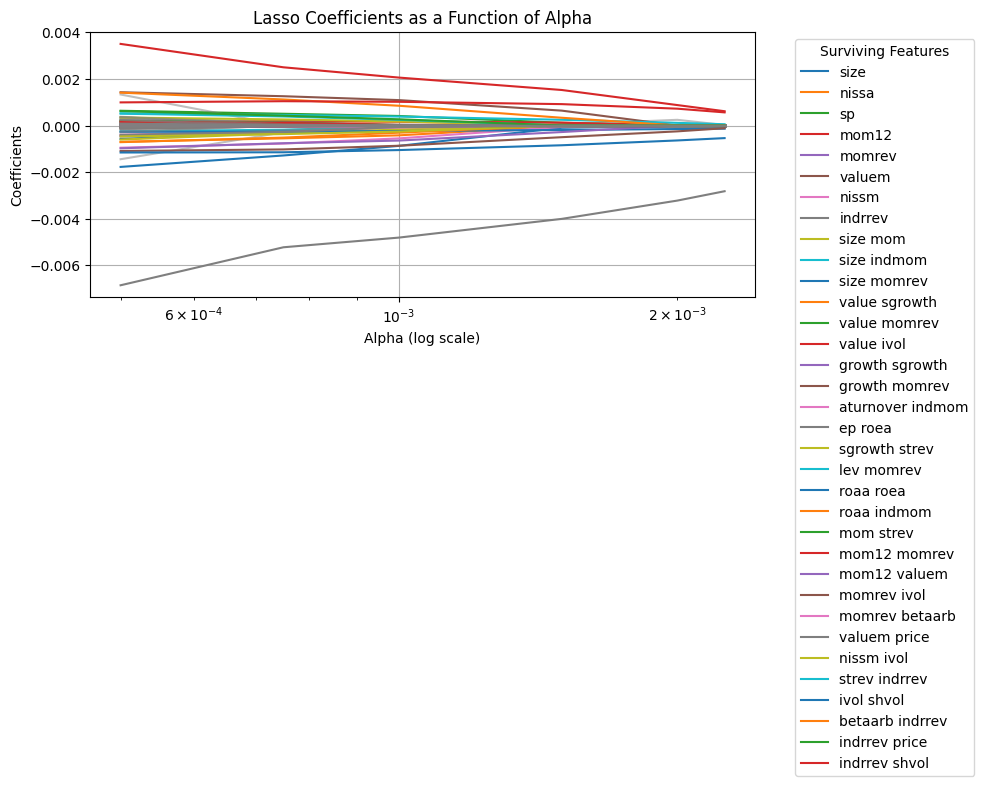

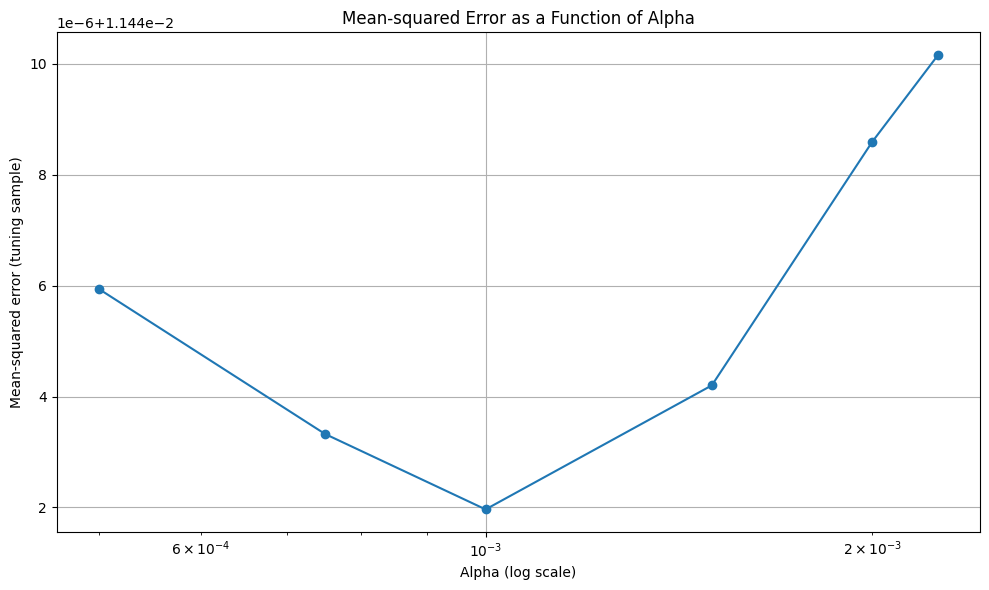

In [ ]:
# Define a range of alpha values
alphas = [0.0005,0.00075,0.001,0.0015,0.002,0.00225]  # range for alphas
coefficients = []
mses=[]
# Perform Lasso regression for each alpha
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)  # Ensure convergence with high iterations
    lasso.fit(X_train_interactions, Y_train)
    coefficients.append(lasso.coef_)
    Y_pred = lasso.predict(X_tuning_interactions)
    mse = mean_squared_error(Y_tuning, Y_pred)
    mses.append(mse)


# Convert coefficients to a NumPy array for plotting
coefficients = np.array(coefficients)


alpha_index = alphas.index(0.001)
surviving_features = np.where(coefficients[alpha_index, :] != 0)[0]

# Plot the coefficients as a function of alpha
plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    if i in surviving_features:
        # Plot surviving features with legend
        plt.plot(alphas, coefficients[:, i], label=feature_names[i])
    else:
        # Plot non-surviving features without legend
        plt.plot(alphas, coefficients[:, i], color='gray', alpha=0.5)

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as a Function of Alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Surviving Features")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Mean-squared error for tuning sample
plt.figure(figsize=(10, 6))
plt.plot(alphas, mses, marker='o')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean-squared error (tuning sample)')
plt.xscale('log')
plt.title('Mean-squared Error as a Function of Alpha')
plt.grid(True)
plt.tight_layout()
plt.show()

Note that there is virtually no improvement out of sample

### Non-Parametric Models

Instead of assuming that the relationship between the dependent variable y and the characteristic size is linear, we consider a more flexible model. In this approach, the relationship is linear in terms of the **percentiles** of the characteristic.

**Original Linear Model**
In a linear regression, the model is typically expressed as:

$$
y_{i, t+1} = \beta \cdot size_{i, t}
$$

where:
- $ y_{i, t+1} $: The dependent variable (e.g., return of asset $ i $ at time $ t+1 $).
- $ size_{i, t} $: A characteristic of asset $ i $ at time $ t $ (e.g., market capitalization).
- $ \beta $: A regression coefficient indicating the relationship between $ size_{i, t} $ and $ y_{i, t+1} $.

**Non-Parametric Percentile-Based Model**

To introduce non-linearity, we instead model $ y_{i, t+1} $ as a function of the percentiles of $ size $ within each time period. The model becomes:


$$y_{i, t+1} = \sum_p \beta_p \cdot 1_{\{size_{i, t} \in \text{Percentile}(p, \text{size}_t)\}}$$

where:
- $ p $: The percentile group (e.g., $ p = 1 $ for the 0-20% percentile, $ p = 2 $ for the 20-40% percentile, etc.).
- $ \beta_p $: The regression coefficient for percentile $ p $.
- $ 1_{\{size_{i, t} \in \text{Percentile}(p, \text{size}_t)\}} $: An indicator function that equals 1 if $ size_{i, t} $ falls in the $ p $-th percentile of the $ size $ distribution for time $ t $, and 0 otherwise.

**Explanation**

1. **Intuition**: Instead of assuming a linear relationship between $ y $ and $ size $, the model captures how $ y $ varies across different percentile ranges of $ size $.
2. **Flexibility**: The model allows for different effects ($ \beta_p $) for each percentile range, enabling it to capture non-linear relationships.
3. **Interpretation**: For example, $ \beta_1 $ represents the average effect of assets in the lowest 20% of $ size $ on $ y $, while $ \beta_5 $ represents the effect for assets in the highest 20%.

This approach is particularly useful when the relationship between $ y $ and $ size $ is not well-approximated by a straight line but instead varies across different ranges of $ size $.

In [ ]:
# Define the number of percentiles
num_percentiles = 5

# Initialize an empty list to store the new columns
new_columns = []
df_processed = df_train.iloc[:, 1:].copy()
# Loop through each characteristic
for characteristic in df_processed.columns:
    # Group by date and calculate percentiles
    grouped = df_processed[characteristic].groupby(level='date')

    # Apply percentile binning for each date
    percentile_bins = grouped.apply(
        lambda x: pd.qcut(x, q=num_percentiles, labels=False, duplicates='drop')  # Bins from 0 to 4
    )

    # After grouped.apply, percentile_bins might have an extra 'date' level in its MultiIndex.
    # We need to drop this redundant outermost level to match the df_processed's index structure.
    if percentile_bins.index.nlevels > df_processed.index.nlevels:
        percentile_bins = percentile_bins.droplevel(0)

    # Create binary columns for each percentile
    for percentile in range(num_percentiles):
        col_name = f"{characteristic}_p{percentile+1}"
        df_processed[col_name] = (percentile_bins == percentile).astype(int)
        df_processed=df_processed.copy()
        new_columns.append(col_name)

# Keep the new columns only for verification (if needed)
new_characteristics_train_df = df_processed[new_columns].copy()


# Initialize an empty list to store the new columns
new_columns = []
df_processed = df_tuning.iloc[:, 1:].copy()
# Loop through each characteristic
for characteristic in df_processed.columns:
    # Group by date and calculate percentiles
    grouped = df_processed[characteristic].groupby(level='date')

    # Apply percentile binning for each date
    percentile_bins = grouped.apply(
        lambda x: pd.qcut(x, q=num_percentiles, labels=False, duplicates='drop')  # Bins from 0 to 4
    )

    # After grouped.apply, percentile_bins might have an extra 'date' level in its MultiIndex.
    # We need to drop this redundant outermost level to match the df_processed's index structure.
    if percentile_bins.index.nlevels > df_processed.index.nlevels:
        percentile_bins = percentile_bins.droplevel(0)

    # Create binary columns for each percentile
    for percentile in range(num_percentiles):
        col_name = f"{characteristic}_p{percentile+1}"
        df_processed[col_name] = (percentile_bins == percentile).astype(int)
        df_processed=df_processed.copy()
        new_columns.append(col_name)

# Keep the new columns only for verification (if needed)
new_characteristics_tuning_df = df_processed[new_columns].copy()



# Output the shape of the new DataFrame
print("Original DataFrame shape:", df_train.iloc[:, 1:].shape)
print("New DataFrame shape after :", new_characteristics_df.iloc[:, 1:].shape)

new_characteristics_train_df

Original DataFrame shape: (204284, 29)
New DataFrame shape after : (204284, 144)


size_p1  size_p2  size_p3  size_p4  size_p5  value_p1  \
date       permno                                                          
1972-07-01 10006         0        0        1        0        0         0   
           10102         0        1        0        0        0         0   
           10137         0        0        0        1        0         0   
           10145         0        0        0        1        0         0   
           10153         1        0        0        0        0         0   
...                    ...      ...      ...      ...      ...       ...   
1991-01-01 90369         1        0        0        0        0         0   
           90609         0        0        0        1        0         1   
           91380         0        0        0        1        0         0   
           91695         1        0        0        0        0         1   
           92655         1        0        0        0        0         1   

                   value_p2  value_p3  value_p4  value_p5  ...  age_p1  \
date       permno                                          ...           
1972-07-01 10006          0         0         1         0  ...       0   
           10102          0         0         0         1  ...       0   
           10137          0         0         1         0  ...       0   
           10145          0         0         0         1  ...       0   
           10153          0         0         0         1  ...       0   
...                     ...       ...       ...       ...  ...     ...   
1991-01-01 90369          0         1         0         0  ...       1   
           90609          0         0         0         0  ...       1   
           91380          1         0         0         0  ...       1   
           91695          0         0         0         0  ...       1   
           92655          0         0         0         0  ...       1   

                   age_p2  age_p3  age_p4  age_p5  shvol_p1  shvol_p2  \
date       permno                                                       
1972-07-01 10006        0       1       0       0         0         0   
           10102        0       1       0       0         0         0   
           10137        0       1       0       0         0         1   
           10145        0       1       0       0         0         0   
           10153        0       1       0       0         0         0   
...                   ...     ...     ...     ...       ...       ...   
1991-01-01 90369        0       0       0       0         0         0   
           90609        0       0       0       0         0         0   
           91380        0       0       0       0         0         0   
           91695        0       0       0       0         0         0   
           92655        0       0       0       0         0         0   

                   shvol_p3  shvol_p4  shvol_p5  
date       permno                                
1972-07-01 10006          0         1         0  
           10102          1         0         0  
           10137          0         0         0  
           10145          0         1         0  
           10153          0         1         0  
...                     ...       ...       ...  
1991-01-01 90369          0         1         0  
           90609          0         0         1  
           91380          1         0         0  
           91695          0         1         0  
           92655          0         0         1  

[204284 rows x 145 columns]

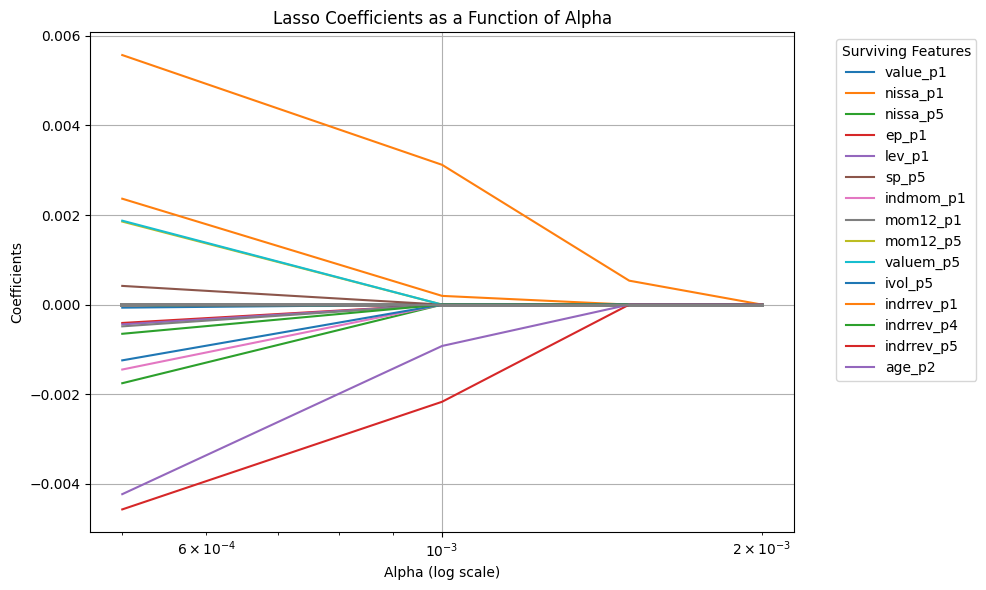

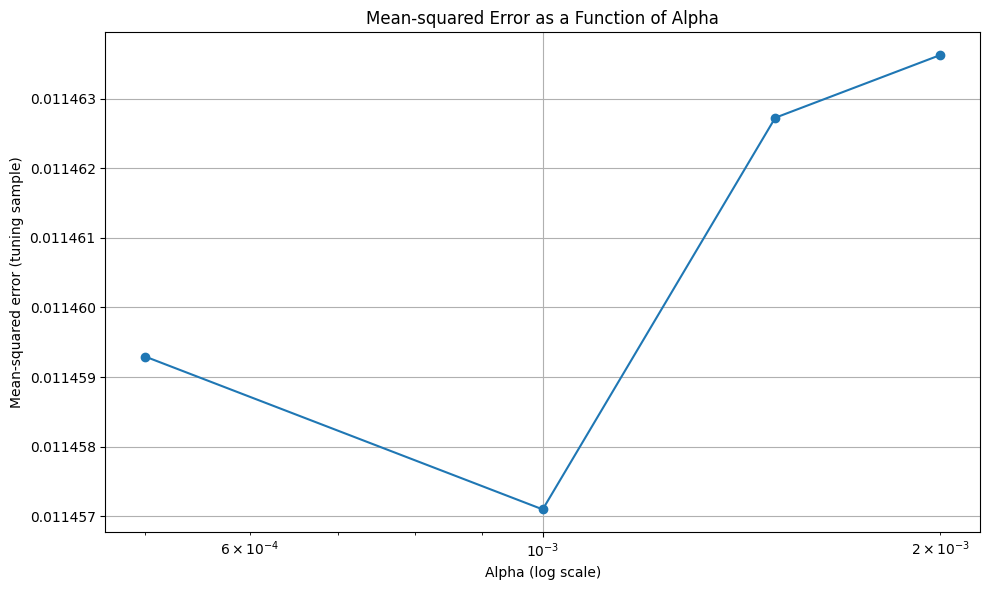

In [ ]:
# Define a range of alpha values
alphas = [0.0005,0.001,0.0015,0.002]  # range for alphas
coefficients = []
mses=[]
# Perform Lasso regression for each alpha
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)  # Ensure convergence with high iterations
    lasso.fit(new_characteristics_train_df.values, Y_train)
    coefficients.append(lasso.coef_)
    Y_pred = lasso.predict(new_characteristics_tuning_df.values)
    mse = mean_squared_error(Y_tuning, Y_pred)
    mses.append(mse)



# Convert coefficients to a NumPy array for plotting
coefficients = np.array(coefficients)


alpha_index = alphas.index(0.0005)
surviving_features = np.where(coefficients[alpha_index, :] != 0)[0]

# Plot the coefficients as a function of alpha
plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    if i in surviving_features:
        # Plot surviving features with legend
        plt.plot(alphas, coefficients[:, i], label=new_characteristics_df.columns[i])
    else:
        # Plot non-surviving features without legend
        plt.plot(alphas, coefficients[:, i], color='gray', alpha=0.5)

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as a Function of Alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Surviving Features")
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot Mean-squared error for tuning sample
plt.figure(figsize=(10, 6))
plt.plot(alphas, mses, marker='o')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean-squared error (tuning sample)')
plt.xscale('log')
plt.title('Mean-squared Error as a Function of Alpha')
plt.grid(True)
plt.tight_layout()
plt.show()



---

## **Random Forest Regression**


![Neural Networks](https://github.com/amoreira2/Fin418/blob/main/assets/plots/regressionTree.jpg?raw=1)


Random Forest is an ensemble method that combines multiple decision trees to make predictions. Each tree is trained on a bootstrap sample of the data, and predictions are averaged:

$$
\hat{y} = \frac{1}{T} \sum_{t=1}^T h_t(X)
$$

Where $ h_t(X) $ is the prediction of the \( t \)-th tree.

- **Key Characteristics**:
  - Reduces overfitting by averaging predictions across trees.
  - Handles non-linear relationships and interactions between features well.
  - Relatively robust to noisy data and outliers.
  - Does not extrapolate beyond the range of the training data.


1. **Random Forest Regressor**:
   - A `RandomForestRegressor` is initialized with:
     - `n_estimators=100`: Builds 100 decision trees.
     - `max_depth=None`: Allows trees to grow until all leaves are pure or contain less than the minimum samples.
     - `random_state=42`: Ensures reproducibility.
     - `n_jobs=-1`: Utilizes all available CPU cores for faster training.


2. **Feature Importances**:
   - The relative importance of each feature is extracted using the `feature_importances_` attribute and displayed in a sorted DataFrame.



3. Adjusting Hyperparameters:
- You can tune the following hyperparameters to optimize model performance:
  - `n_estimators`: Increase or decrease the number of trees.
  - `max_depth`: Limit the depth of trees to prevent overfitting.
  - `min_samples_split`: Minimum number of samples required to split an internal node.
  - `min_samples_leaf`: Minimum number of samples required to be at a leaf node.


In [13]:

from sklearn.ensemble import RandomForestRegressor




# Build the Random Forest Regressor
random_forest = RandomForestRegressor(
    n_estimators=50,  # Number of trees in the forest
    max_depth=3,    # Maximum depth of the trees
    random_state=42,   # Ensures reproducibility
    n_jobs=-1          # Use all available cores for training
)

# Train the Random Forest model
random_forest.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = random_forest.predict(X_tuning)

# Evaluate the model
mse = mean_squared_error(Y_tuning, Y_pred)
r2 = r2_score(Y_tuning, Y_pred)

mse = mean_squared_error(Y_tuning, Y_pred)
print("Mean Squared Error (MSE):", mse)

mae= mean_absolute_error(Y_tuning, Y_pred)
print("Mean Absolute Error (MAE):", mae)

r2 = r2_score(Y_tuning, Y_pred)
print("R-squared (R2):", r2)

# Optional: Feature importance
feature_importances = random_forest.feature_importances_
feature_names = df_train.iloc[:, 1:].columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)


Mean Squared Error (MSE): 0.011450041255742194
Mean Absolute Error (MAE): 0.07447397468980559
R-squared (R2): 7.542495185886011e-05

Feature Importances:
      Feature  Importance
4     debtiss    0.581639
25    indrrev    0.188957
6       nissa    0.080906
5     repurch    0.053310
20     valuem    0.030706
23       ivol    0.026072
16        mom    0.014695
28      shvol    0.009024
26      price    0.006108
24    betaarb    0.003942
18      mom12    0.003188
27        age    0.000761
0        size    0.000690
12        lev    0.000000
11    sgrowth    0.000000
10         ep    0.000000
9    gmargins    0.000000
8   aturnover    0.000000
7      growth    0.000000
2        prof    0.000000
3      fscore    0.000000
1       value    0.000000
19     momrev    0.000000
14       roea    0.000000
15         sp    0.000000
13       roaa    0.000000
17     indmom    0.000000
21      nissm    0.000000
22      strev    0.000000



---

## **Gradient Boosted Regression Trees (GBRT)**
GBRT is an ensemble technique that builds trees sequentially, where each tree corrects the errors of the previous one. The prediction is updated iteratively:

$$
\hat{y}_t(X) = \hat{y}_{t-1}(X) + \nu \cdot g_t(X)
$$

Where:
- $ g_t(X) $: Gradient of the loss function with respect to predictions.
- $ \nu$: Learning rate, controlling the contribution of each tree.

- **Key Characteristics**:
  - Optimizes a differentiable loss function (e.g., squared error for regression).
  - Can capture complex, non-linear patterns in the data.
  - Requires careful tuning of hyperparameters (e.g., learning rate, number of trees, maximum tree depth).



1. **Gradient Boosted Regression Trees**:
   - A `GradientBoostingRegressor` is initialized with:
     - `n_estimators=100`: Builds 100 trees.
     - `learning_rate=0.1`: Controls the contribution of each tree to the final prediction.
     - `max_depth=3`: Limits the depth of individual trees to prevent overfitting.
     - `random_state=42`: Ensures reproducibility.


2. **Adjusting Hyperparameters**:
- You can tune the following hyperparameters to optimize the model:
  - `n_estimators`: Increase for more stages of boosting.
  - `learning_rate`: Decrease for smaller incremental updates (often requires increasing `n_estimators`).
  - `max_depth`: Control tree depth to balance bias and variance.
  - `subsample`: Use a fraction of samples for each stage (e.g., `subsample=0.8` for 80% of the data).





In [14]:

from sklearn.ensemble import GradientBoostingRegressor




# Build the Gradient Boosting Regressor
gbrt = GradientBoostingRegressor(
    n_estimators=50,       # Number of boosting stages to perform
    learning_rate=0.2,      # Shrinks the contribution of each tree
    max_depth=3,            # Maximum depth of each tree
    random_state=42         # Ensures reproducibility
)

# Train the Gradient Boosting model
gbrt.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = gbrt.predict(X_tuning)

# Evaluate the model
mse = mean_squared_error(Y_tuning, Y_pred)
r2 = r2_score(Y_tuning, Y_pred)

mse = mean_squared_error(Y_tuning, Y_pred)
print("Mean Squared Error (MSE):", mse)

mae= mean_absolute_error(Y_tuning, Y_pred)
print("Mean Absolute Error (MAE):", mae)

r2 = r2_score(Y_tuning, Y_pred)
print("R-squared (R2):", r2)

# Optional: Feature importance
feature_importances = gbrt.feature_importances_
feature_names = df_train.iloc[:, 1:].columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)


Mean Squared Error (MSE): 0.011948129643274456
Mean Absolute Error (MAE): 0.07697346355195878
R-squared (R2): -0.04342230646372336

Feature Importances:
      Feature  Importance
5     repurch    0.370275
4     debtiss    0.369992
6       nissa    0.109332
3      fscore    0.038168
25    indrrev    0.023693
27        age    0.018241
23       ivol    0.013273
18      mom12    0.011229
26      price    0.008908
21      nissm    0.008055
24    betaarb    0.005189
28      shvol    0.004789
20     valuem    0.004599
17     indmom    0.002590
10         ep    0.001971
22      strev    0.001831
8   aturnover    0.001296
16        mom    0.001198
12        lev    0.001158
2        prof    0.001071
15         sp    0.001040
13       roaa    0.000543
0        size    0.000471
19     momrev    0.000465
11    sgrowth    0.000436
1       value    0.000187
7      growth    0.000000
9    gmargins    0.000000
14       roea    0.000000




---

## **Elastic Net Regression**
Elastic Net combines L1 (Lasso) and L2 (Ridge) regularization to balance feature selection and multicollinearity handling. The objective function is:

$$
\min_{\beta} \left( \frac{1}{2n} \sum_{i=1}^n (y_i - X_i^\top \beta)^2 + \alpha_1 \|\beta\|_1 + \alpha_2 \|\beta\|_2^2 \right)
$$

Where:
- $ \|\beta\|_1 $: Lasso penalty encourages sparsity.
- $ \|\beta\|_2^2 $: Ridge penalty shrinks coefficients to reduce multicollinearity.

- **Key Characteristics**:
  - Balances Lasso's feature selection and Ridge's stability with correlated predictors.
  - Controlled by two hyperparameters:
    - $ \alpha $: Overall regularization strength.
    - $ \rho $ (mixing ratio): Balance between L1 and L2 penalties.




1. **Elastic Net Regressor**:
   - The `ElasticNet` regressor is initialized with:
     - `alpha=0.1`: Controls the overall strength of regularization.
     - `l1_ratio=0.5`: Specifies the mix of L1 (Lasso) and L2 (Ridge) penalties:
       -  l1_ratio=0 : Equivalent to Ridge regression.
       -  l1_ratio=1 : Equivalent to Lasso regression.
       -  l1_ratio=0.5 : Balances L1 and L2 penalties.
     - `random_state=42`: Ensures reproducibility.

2. **Adjusting Hyperparameters**:
- **`alpha`**:
  - Larger values apply stronger regularization, reducing overfitting but increasing bias.
- **`l1_ratio`**:
  - Adjust to control the balance between L1 and L2 penalties:
    - Increase towards 1 for more sparsity (feature selection).
    - Decrease towards 0 to favor Ridge-like behavior (handles multicollinearity).





In [16]:
from sklearn.linear_model import ElasticNet

# Initialize and train the Elastic Net regressor
elastic_net = ElasticNet(
    alpha=0.001,       # Regularization strength (higher values = stronger penalty)
    l1_ratio=0.5,    # Balance between L1 (Lasso) and L2 (Ridge) regularization
    random_state=42  # Ensures reproducibility
)

# Train the Elastic Net model
elastic_net.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = elastic_net.predict(X_tuning)

# Evaluate the model
mse = mean_squared_error(Y_tuning, Y_pred)
r2 = r2_score(Y_tuning, Y_pred)

mse = mean_squared_error(Y_tuning, Y_pred)
print("Mean Squared Error (MSE):", mse)

mae= mean_absolute_error(Y_tuning, Y_pred)
print("Mean Absolute Error (MAE):", mae)

r2 = r2_score(Y_tuning, Y_pred)
print("R-squared (R2):", r2)

# Print the coefficients
coefficients = pd.DataFrame({
    'Feature': df_train.iloc[:, 1:].columns,
    'Coefficient': elastic_net.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nCoefficients:")
print(coefficients)


Mean Squared Error (MSE): 0.0114476248931202
Mean Absolute Error (MAE): 0.07443452451525671
R-squared (R2): 0.00028644431100299794

Coefficients:
      Feature  Coefficient
18      mom12     0.003526
22      strev     0.002188
20     valuem     0.001659
15         sp     0.000756
3      fscore     0.000371
5     repurch     0.000235
14       roea     0.000163
2        prof     0.000163
10         ep     0.000000
11    sgrowth     0.000000
8   aturnover     0.000000
4     debtiss    -0.000000
1       value     0.000000
27        age    -0.000000
26      price    -0.000000
24    betaarb    -0.000000
12        lev     0.000000
9    gmargins     0.000000
17     indmom     0.000000
13       roaa     0.000000
7      growth    -0.000072
23       ivol    -0.000332
21      nissm    -0.000454
0        size    -0.000622
6       nissa    -0.000697
28      shvol    -0.000777
19     momrev    -0.000898
16        mom    -0.001098
25    indrrev    -0.006143



---



## **Neural Network Regression**

![Neural Networks](https://github.com/amoreira2/Fin418/blob/main/assets/plots/neural_networks.jpg?raw=1)

A neural network is a flexible, non-linear model that uses layers of neurons to approximate complex relationships between inputs (\( X \)) and outputs (\( Y \)). The simplest form of a feedforward neural network can be expressed as:

$$
\hat{y} = f(W^{[L]} \sigma(W^{[L-1]} \dots \sigma(W^{[1]} X + b^{[1]}) + b^{[L-1]}) + b^{[L]}
$$

- **Key Characteristics**:
  - Consists of an input layer, hidden layers, and an output layer.
  - Activation functions ($\sigma$, e.g., ReLU or sigmoid) introduce non-linearity.
    - $ReLU(x)=max(0,x)$
    - $Sigmoid(x)=1/(1+e^{−x})$
  - The number of layers and neurons can be tuned to fit data complexity.
  - Requires careful tuning of hyperparameters (e.g., learning rate, number of layers, epochs).


  
1. **Building the Neural Network**:
   - **Function `build_and_train_model`**:
     - **Parameters**:
       - `num_layers`: Number of layers in the neural network (free parameter).
       - `input_dim`: Number of input features (dimensions).

     - **Model Architecture**:
       - **Input Layer**:
         - Uses `Dense` layer with 64 neurons and `relu` activation function.
         - `input_dim` specifies the number of input features.
       - **Hidden Layers**:
         - Adds additional hidden layers based on `num_layers`.
         - Each hidden layer has 64 neurons with `relu` activation.
       - **Output Layer**:
         - A single neuron without activation (linear activation) for regression output.
     - **Compilation**:
       - Uses the `adam` optimizer and `mean_squared_error` loss function suitable for regression tasks.
     - **Training**:
          In addition to the network structure (layers and neurons), you also have to pick parameters that control the training process


          Epochs: Controls the total number of training cycles. More epochs mean more opportunities for the model to learn, but excessive epochs can lead to overfitting.

          Batch Size: Controls how the dataset is split into smaller subsets for gradient updates. Balances memory usage and convergence speed.

          Validation Split: Reserves a portion of the data to monitor generalization during training and guide callbacks like early stopping.


          By carefully tuning these parameters, you can balance training efficiency, model generalization, and computational resources.


 Adjusting the Number of Layers:

- **Free Parameter**:
  - You can adjust the `num_layers` variable to change the depth of the neural network.
  - For example, setting `num_layers = 5` will create a network with one input layer and four hidden layers.

 Additional Considerations:

- **Hyperparameter Tuning**:
  - You might want to experiment with different numbers of neurons, activation functions, epochs, and batch sizes to improve model performance.





  

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [28]:
def build_and_train_model(num_layers, input_dim, X_train, Y_train,neurons,validation_data,epochs):
    """
    Builds and trains a neural network model.

    Parameters:
    - num_layers: int, number of layers in the neural network
    - input_dim: int, number of input features
    - X_train: training features
    - Y_train: training target

    Returns:
    - model: Trained Keras model
    """
    model = Sequential()
    # Add the input layer

    model.add(Dense(neurons, activation='relu', input_dim=input_dim))

    # Add hidden layers
    for _ in range(num_layers - 1):
        neurons = max(1, int(neurons * 0.5))
        model.add(Dense(neurons, activation='relu'))

    # Add the output layer
    model.add(Dense(1))  # Single neuron for regression output

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(
        X_train, Y_train,
        epochs=epochs,                # You can adjust the number of epochs
        batch_size=128,            # You can adjust the batch size
        validation_data=validation_data,
    )
    return model

# Specify the number of layers (free parameter)
num_layers = 5  # Adjust this number as needed
neurons=64

input_dim = X_train.shape[1]

# Build and train the model
model = build_and_train_model(num_layers, input_dim, X_train ,Y_train.values,neurons,(X_tuning, Y_tuning.values),epochs=10)



Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1596/1596 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0105 - val_loss: 0.0115
Epoch 2/10
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 3/10
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 4/10
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0096 - val_loss: 0.0115
Epoch 5/10
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 6/10
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 7/10
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 8/10
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0095 - val_loss: 0.0115
Epoch 9/10
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0096 - val_loss: 0.0115
Epoch 10/10
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0094 - val_loss: 0.0115


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Shape of combined_returns: (457, 2)


Predicted_NN_Return  Average_Historical_Return
date       permno                                                
2001-01-01 10078              0.005304                   0.027460
           10104             -0.016637                   0.002824
           10107              0.006775                   0.062721
           10108              0.010268                  -0.160686
           10137              0.011617                   0.005378

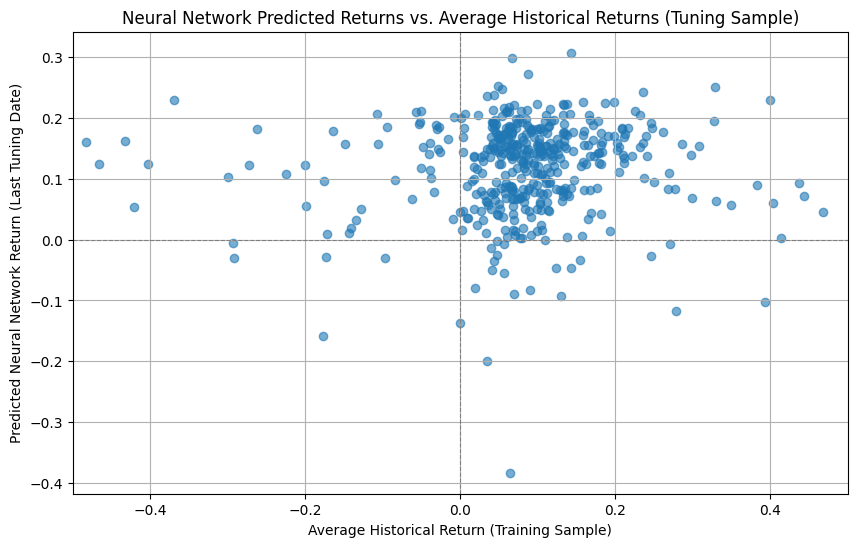

<Axes: >

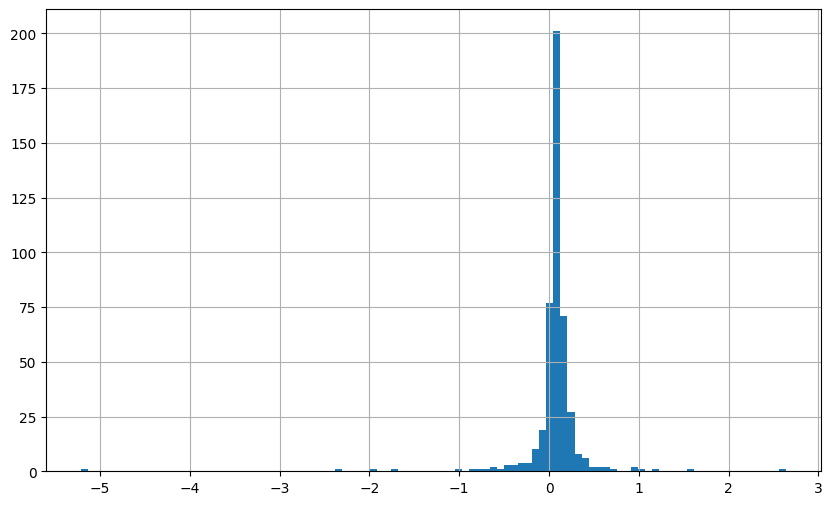

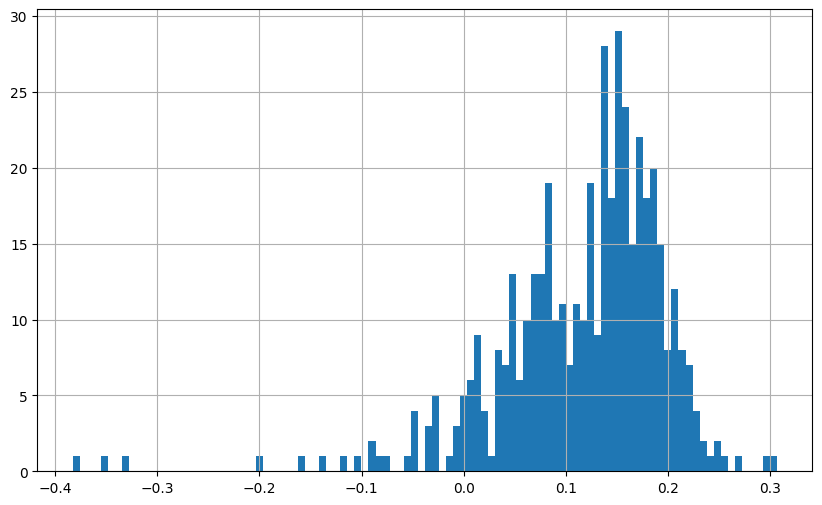

In [34]:
last_tuning_date = X_tuning.index.get_level_values(0).unique().max()
X_tuning_last_date = X_tuning.loc[last_tuning_date]
predicted_returns_nn = model.predict(X_tuning_last_date)
predicted_returns_nn_df = pd.DataFrame(predicted_returns_nn, index=X_tuning_last_date.index, columns=['Predicted_NN_Return'])
average_historical_returns = Y_train.groupby('permno').mean()
average_historical_returns_df = pd.DataFrame(average_historical_returns)
average_historical_returns_df.columns = ['Average_Historical_Return']

combined_returns = predicted_returns_nn_df.merge(average_historical_returns_df, left_index=True, right_index=True, how='inner')
print(f"Shape of combined_returns: {combined_returns.shape}")
display(combined_returns.head())

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(combined_returns['Average_Historical_Return']*12, combined_returns['Predicted_NN_Return']*12, alpha=0.6)
plt.title('Neural Network Predicted Returns vs. Average Historical Returns (Tuning Sample)')
plt.xlabel('Average Historical Return (Training Sample)')
plt.ylabel('Predicted Neural Network Return (Last Tuning Date)')
plt.grid(True)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
plt.xlim([-0.5,0.50])
plt.show()

plt.figure(figsize=(10, 6))

(combined_returns['Average_Historical_Return']*12).hist(bins=100)


plt.figure(figsize=(10, 6))

(combined_returns['Predicted_NN_Return']*12).hist(bins=100)

### Adding Regularization

Neureal networks do not have any regularization--they are paraemter rich

You might want to impose some

1. L1/L2 penalties (like LASSO/Ridge) via kernel_regularizer

2. Decoupled weight decay (AdamW)

3. Dropout (implicit regularization)

- If you want the LASSO feel: set a small l1 (e.g., 1e-6–1e-4) and keep l2 modest (or 0).

- If you want ridge/weight decay: prefer l2 (1e-5–1e-3). For decoupled AdamW, set weight_decay=1e-5 (and keep l2 smaller or 0 to avoid double-penalizing).

- Dropout of 0.1–0.3 is a good starting range.

Use EarlyStopping (to avoid overfitting/overtraining.)

In [35]:
# addign regularization

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# If your TF version has AdamW:
try:
    from tensorflow.keras.optimizers import AdamW  # TF 2.11+ (or 2.13+ stable)
    _HAS_ADAMW = True
except Exception:
    _HAS_ADAMW = False
    # Optional: pip install tensorflow-addons and use:
    # import tensorflow_addons as tfa

def build_and_train_model(
    num_layers,
    input_dim,
    X_train,
    Y_train,
    neurons,
    validation_data,
    epochs,
    # --- regularization knobs ---
    l1=0.0,          # set >0 for LASSO-like shrinkage (e.g., 1e-7 to 1e-4)
    l2=1e-4,         # common L2 strength (e.g., 1e-5 to 1e-3)
    dropout_rate=0.0,# e.g., 0.1–0.3
    weight_decay=None,# e.g., 1e-5 for AdamW; leave None to skip
    lr=1e-3,
    batch_size=128,
    use_early_stopping=True,
    patience=10
):
    """
    Adds L1/L2 regularization to weights, optional dropout, and optional AdamW weight decay.
    """
    reg = regularizers.l1_l2(l1=l1, l2=l2) if (l1 > 0 or l2 > 0) else None

    model = Sequential()
    # Input + first hidden
    model.add(Dense(neurons, activation='relu', input_dim=input_dim, kernel_regularizer=reg))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Additional hidden layers
    width = neurons
    for _ in range(num_layers - 1):
        width = max(1, int(width * 0.5))
        model.add(Dense(width, activation='relu', kernel_regularizer=reg))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output layer (usually do NOT regularize output in regression)
    model.add(Dense(1))

    # Optimizer: AdamW (decoupled weight decay) if requested; else vanilla Adam
    if weight_decay is not None and weight_decay > 0:
        if _HAS_ADAMW:
            optimizer = AdamW(learning_rate=lr, weight_decay=weight_decay)
        else:
            # Fallback: approximate with kernel_regularizer only,
            # or install tensorflow-addons and uncomment the next two lines:
            # import tensorflow_addons as tfa
            # optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=weight_decay)
            optimizer = Adam(learning_rate=lr)  # graceful fallback
    else:
        optimizer = Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[])

    callbacks = []
    if use_early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True))

    model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        callbacks=callbacks,
        verbose=1
    )
    return model




In [ ]:
num_layers = 5
neurons = 64
input_dim = X_train.shape[1]

model = build_and_train_model(
    num_layers=num_layers,
    input_dim=input_dim,
    X_train=X_train,
    Y_train=Y_train.values,
    neurons=neurons,
    validation_data=(X_tuning, Y_tuning.values),
    epochs=10,
    # --- regularization choices ---
    l1=0.0,          # set to e.g. 1e-6 if you want L1 sparsity
    l2=0,         # Ridge-like shrinkage
    dropout_rate=0.2,# mild dropout
    weight_decay=1e-5,# AdamW (if available); set None to skip
    lr=1e-3
)



## The Whole Shebang


You can potentially combine a non-parametric  Model with interactions.

The key issue is tha as you make the model richer and richer the scope for the training to produce garabage increases--

so you need

- more and more data
- much more validation/model regularization

Examples include

- L1 regularization:L1 regularization adds a penalty to the loss function based on the absolute values of the weights, encouraging sparsity by driving some weights to zero. This prevents overfitting and simplifies the model, making it useful in high-dimensional data or feature selection.
- Early stopping: Early stopping monitors validation loss during training and halts when the loss stops improving, preventing overfitting. It ensures the model generalizes well and avoids unnecessary training.
- Batch normalization: Batch normalization normalizes layer inputs to have a mean of 0 and variance of 1, speeding up training and reducing sensitivity to initialization. It also acts as a regularizer by introducing noise during training.
- Ensembles: Ensembles combine predictions from multiple models, reducing variance and improving accuracy. They are effective for generalization but increase computational cost.



---

## Wrap up


Comparison  Table across methods

| **Model**                  | **Type**       | **Key Strengths**                                        | **Limitations**                            |
|----------------------------|----------------|----------------------------------------------------------|--------------------------------------------|
| Lasso Regression           | Linear         | Feature selection, interpretable coefficients           | Struggles with multicollinearity           |
| Neural Network Regression   | Non-linear     | Flexible, captures complex patterns                     | Requires significant tuning and data       |
| Random Forest Regression    | Non-linear     | Robust to overfitting, handles feature interactions well | Computationally expensive for large data   |
| GBRT                       | Non-linear     | Accurate, optimizes for specific loss functions         | Sensitive to hyperparameters, overfitting  |
| Elastic Net Regression      | Linear         | Handles multicollinearity, balances selection & stability | Can be slower than Ridge or Lasso          |



For an academic investigation of these methods see  "Empirical Asset Pricing via Machine Learning" (https://academic.oup.com/rfs/article/33/5/2223/5758276?login=true). The figures used in this notebook are also from that paper.

## 🧠 Key Takeaways

- Start with **simple, strong baselines** (logistic/linear + regularization), then escalate to ensembles or deep nets if justified by data.  
- **Pipelines** with proper Cross Validation prevent leakage; evaluate **out-of-sample** with task-appropriate metrics.  
- Use **regularization and early stopping** to control variance; track **learning curves** to diagnose bias vs. variance.  

